### GASS UVW

Notebook to test the uv coverage computation for an observation with a radio interferometer.

In [199]:
using Distances , Random 
using PyCall
using DataFrames
using LinearAlgebra

import CSV 

rootdir = "/home/stephane/alma/ArrayConfig/GASS"

push!(LOAD_PATH,"$rootdir/master/src")
using GASS

import PyPlot

@pyimport astroquery.vizier as vizier
@pyimport astropy.units as u
@pyimport astropy.coordinates as coord

## directory
datadir = "$rootdir/master/data"
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/test"

cd(wdir)

### UVW methods

Several to manipulate and analyze uv-coverage in (radio) interferometry. The examples are taken from ALMA, a (sub-) millieter radio interferometer located in the desert of Atacama, Chile

In [200]:
## baseline coordinates
## arr: DataFrames with at least :X, :Y, :Z
## check at https://web.njit.edu/~gary/728/Lecture6.html

function calc_baselines(arr::AbstractDataFrame , lat=-23.0262015)
    
    coordinates= vcat(hcat(convert(Vector{Float64},arr[:X]))' ,
        hcat(convert(Vector{Float64},arr[:Y]))' ,
        hcat(convert(Vector{Float64},arr[:Z]))')
    rot= [0 -sind(lat) cosd(lat) ; 1 0 0 ; 0  cosd(lat)  sind(lat)]
    xyz= *(rot,coordinates)
    
    Nc= size(xyz)
    Nbl= convert(Int64,(Nc[2]*(Nc[2]-1))/2)   
    Bl= zeros(Float64,3,2Nbl)   ## symmetry of the bl
    
    ibl= 1
    for i in 1:Nc[2]
        for j in i+1:Nc[2]
            Bl[1,ibl]= xyz[1,i]-xyz[1,j] ; Bl[1,ibl+Nbl]= xyz[1,j]-xyz[1,i]
            Bl[2,ibl]= xyz[2,i]-xyz[2,j] ; Bl[2,ibl+Nbl]= xyz[2,j]-xyz[2,i]
            Bl[3,ibl]= xyz[3,i]-xyz[3,j] ; Bl[3,ibl+Nbl]= xyz[3,j]-xyz[3,i]
            ibl += 1
        end
    end
    return(Bl)
end

calc_baselines (generic function with 2 methods)

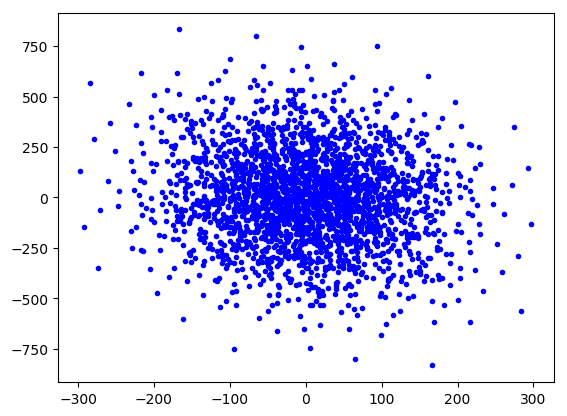

In [201]:
### Main
macro main(inpfile)
    cfg = read_cfg(inpfile)
    
    ## array test
    bl= calc_baselines(cfg.arr)
    
    PyPlot.plot(bl[1,:],bl[2,:], "b.")
    PyPlot.show()
    
end

@main("../master/data/GA_Inputs_O-10.txt.julia")